Tentativa Unet Machine Learning

In [1]:
import SimpleITK as sitk
import numpy as np
import os


Criar de Pastas

In [2]:
def output(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

Dados NRRD

In [2]:
imagens_nrrd = "C:/Users/User/Desktop/UNetTraining/imagens_nrrd"
saida_imagem = "C:/Users/User/Desktop/UNetTraining/treino/imagens.png"
imagens_testepng = "C:/Users/User/Desktop/UNetTraining/treino/imagens.png"

mascaras_nrrd = "C:/Users/User/Desktop/UNetTraining/mascaras_nrrd"
saida_mascaras = "C:/Users/User/Desktop/UNetTraining/treino/mascaras.png"
mascaras_png = "C:/Users/User/Desktop/UNetTraining/treino/mascaras.png"

valmascaras_nrrd = "C:/Users/User/Desktop/UNetTraining/val.mascaras.nrrd"
valsaida_mascaras = "C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png"
valmascaras_png = "C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png"

valimagens_nrrd = "C:/Users/User/Desktop/UNetTraining/val.imagem.nrrd"
valsaida_imagem = "C:/Users/User/Desktop/UNetTraining/validacao/val.imagem.png"
valimagens_png = "C:/Users/User/Desktop/UNetTraining/validacao/val.imagem.png"


Criar pastas para guardar arquivos PNG

In [4]:
output(saida_imagem)
output(saida_mascaras)
output(valsaida_imagem)
output(valsaida_mascaras)

Leitura dos arquivos NRRD

In [9]:
arquivo_imagens_nrrd = [f for f in os.listdir(imagens_nrrd) if f.endswith('.nrrd')]
arquivo_mascaras_nrrd = [f for f in os.listdir(mascaras_nrrd) if f.endswith('.nrrd')]
arquivo_valimagens_nrrd = [f for f in os.listdir(valimagens_nrrd) if f.endswith('.nrrd')]
arquivo_valmascaras_nrrd = [f for f in os.listdir(valmascaras_nrrd) if f.endswith('.nrrd')]


In [ ]:

if len(arquivo_imagens_nrrd) == 0:
    print("Nenhum arquivo NRRD encontrado na pasta.")
else:

    for arquivo in arquivo_imagens_nrrd:
        caminho_imagens = os.path.join(imagens_nrrd, arquivo)
        try:              
            imagem = sitk.ReadImage(caminho_imagens)
            imagem_array = sitk.GetArrayViewFromImage(imagem)
            print(f"Arquivo {arquivo} lido com sucesso!")
        except Exception as e:
            print(f"Erro ao carregar a máscara {arquivo}: {e}")

if len(arquivo_mascaras_nrrd) == 0:
    print("Nenhum arquivo NRRD encontrado na pasta.")
else:

    for arquivo in arquivo_mascaras_nrrd:
        caminho_mascaras = os.path.join(mascaras_nrrd, arquivo)
        try:              
            mascaras = sitk.ReadImage(caminho_mascaras)
            mascaras_array = sitk.GetArrayViewFromImage(mascaras)
            print(f"Arquivo {arquivo} lido com sucesso!")
        except Exception as e:
            print(f"Erro ao carregar a máscara {arquivo}: {e}")



Arquivo testeimagem.nrrd lido com sucesso!
Arquivo Segmentation_caso1.nrrd lido com sucesso!


Quebrar em fatias e salvá-las

In [7]:
from PIL import Image

In [13]:
for i, slice in enumerate(imagem_array):
    if slice.max() != slice.min():
        slice_imagem_padronizado = ((slice - slice.min()) / (slice.max() - slice.min()) * 255).astype(np.uint8)
    else:
        slice_imagem_padronizado = np.zeros_like(slice, dtype=np.uint8)  
        
    img = Image.fromarray(slice_imagem_padronizado)
    img.save(os.path.join(saida_imagem, f"slice_{i:03d}.png"))


for i, slice in enumerate(mascaras_array):
    
    if slice.max() != slice.min():
        slice_mascaras_padronizado = ((slice - slice.min()) / (slice.max() - slice.min()) * 255).astype(np.uint8)
    else:
        slice_mascaras_padronizado = np.zeros_like(slice, dtype=np.uint8)  
 
    mask = Image.fromarray(slice_mascaras_padronizado)
    mask.save(os.path.join(saida_mascaras, f"mascara_{i:03d}.png"))

print("Imagens e máscaras processadas e salvas com sucesso!")



Imagens e máscaras processadas e salvas com sucesso!


Pré-Processamento

In [10]:
import tensorflow as tf
import keras 
import tensorflow.python.keras as keras
from keras_preprocessing.image import ImageDataGenerator, array_to_img
from keras_preprocessing.image import load_img, img_to_array, save_img
import matplotlib.pyplot as plt



pre_img = "C:/Users/User/Desktop/UNetTraining/pre_img"
pre_mask = "C:/Users/User/Desktop/UNetTraining/pre_mask"
pre_valimg = "C:/Users/User/Desktop/UNetTraining/pre_valimg"
pre_valmask = "C:/Users/User/Desktop/UNetTraining/pre_valmask"

In [11]:
def preprocessamento(input_dir, output_dir, target_size=(256,256)):
    for file_name in os.listdir(input_dir):
            img = load_img(os.path.join(input_dir, file_name), target_size=target_size, color_mode='grayscale')
            imagem_array = img_to_array(img)
            save_img(os.path.join(output_dir,file_name), imagem_array)


In [12]:
preprocessamento(imagens_testepng, pre_img)
preprocessamento(mascaras_png, pre_mask)


In [13]:
preprocessamento(valimagens_png, pre_valimg)
preprocessamento(valmascaras_png, pre_valmask)

Carregar dados obtidos

In [14]:
def carregar_dados_lotes_unidos(pre_img, pre_mask, batch_size=16, target_size=(256, 256)):
    if not os.path.exists(pre_img) or not os.path.exists(pre_mask):
        raise ValueError("Os diretórios não existem")
    
 
    arquivos_imagem = sorted(os.listdir(pre_img))
    arquivos_mascara = sorted(os.listdir(pre_mask))

    imagens, mascaras = [], []

    for img_name, mask_name in zip(arquivos_imagem, arquivos_mascara):
        print(f"Lendo imagem: {img_name} e máscara: {mask_name}") 

        
        img = tf.keras.utils.load_img(
            os.path.join(pre_img, img_name), 
            target_size=target_size, 
            color_mode='grayscale'
        )
        mask = tf.keras.utils.load_img(
            os.path.join(pre_mask, mask_name), 
            target_size=target_size, 
            color_mode='grayscale'
        )

       
        img_array = tf.keras.utils.img_to_array(img)
        mask_array = tf.keras.utils.img_to_array(mask)

        imagens.append(img_array)
        mascaras.append(mask_array)

  
    imagens = np.array(imagens)
    mascaras = np.array(mascaras)

    return imagens, mascaras

In [56]:
pre_img = "C:/Users/User/Desktop/UNetTraining/pre_img"
pre_mask = "C:/Users/User/Desktop/UNetTraining/pre_mask"

In [15]:
imagens, mascaras = carregar_dados_lotes_unidos(pre_img, pre_mask, batch_size=16, target_size=(256, 256))

Lendo imagem: slice_000.png e máscara: mascara_000.png
Lendo imagem: slice_001.png e máscara: mascara_001.png
Lendo imagem: slice_002.png e máscara: mascara_002.png
Lendo imagem: slice_003.png e máscara: mascara_003.png
Lendo imagem: slice_004.png e máscara: mascara_004.png
Lendo imagem: slice_005.png e máscara: mascara_005.png
Lendo imagem: slice_006.png e máscara: mascara_006.png
Lendo imagem: slice_007.png e máscara: mascara_007.png
Lendo imagem: slice_008.png e máscara: mascara_008.png
Lendo imagem: slice_009.png e máscara: mascara_009.png
Lendo imagem: slice_010.png e máscara: mascara_010.png
Lendo imagem: slice_011.png e máscara: mascara_011.png
Lendo imagem: slice_012.png e máscara: mascara_012.png
Lendo imagem: slice_013.png e máscara: mascara_013.png
Lendo imagem: slice_014.png e máscara: mascara_014.png
Lendo imagem: slice_015.png e máscara: mascara_015.png
Lendo imagem: slice_016.png e máscara: mascara_016.png
Lendo imagem: slice_017.png e máscara: mascara_017.png
Lendo imag

In [16]:
def carregar_val_dados_lotes_unidos(pre_valimg, pre_valmask, batch_size=16, target_size=(256, 256)):
    if not os.path.exists(pre_valimg) or not os.path.exists(pre_valmask):
        raise ValueError("Os diretórios não existem")
    
   
    arquivos_valimagem = sorted(os.listdir(pre_valimg))
    arquivos_valmascara = sorted(os.listdir(pre_valmask))

    valimagens, valmascaras = [], []

    for valimg_name, valmask_name in zip(arquivos_valimagem, arquivos_valmascara):
        print(f"Lendo imagem: {valimg_name} e máscara: {valmask_name}")  

       
        valimg = tf.keras.utils.load_img(
            os.path.join(pre_valimg, valimg_name), 
            target_size=target_size, 
            color_mode='grayscale'
        )
        valmask = tf.keras.utils.load_img(
            os.path.join(pre_valmask, valmask_name), 
            target_size=target_size, 
            color_mode='grayscale'
        )

       
        valimg_array = tf.keras.utils.img_to_array(valimg)
        valmask_array = tf.keras.utils.img_to_array(valmask)

        valimagens.append(valimg_array)
        valmascaras.append(valmask_array)

    
    valimagens = np.array(valimagens)
    valmascaras = np.array(valmascaras)

    return valimagens, valmascaras

In [52]:
pre_valimg = "C:/Users/User/Desktop/UNetTraining/pre_valimg"
pre_valmask = "C:/Users/User/Desktop/UNetTraining/pre_valmask"

In [17]:
valimagens, valmascaras = carregar_val_dados_lotes_unidos(pre_valimg, pre_valmask, batch_size=16, target_size=(256, 256))

Lendo imagem: slice_000_aug_1.png e máscara: mascara_000_aug_1.png
Lendo imagem: slice_001_aug_1.png e máscara: mascara_001_aug_1.png
Lendo imagem: slice_002_aug_1.png e máscara: mascara_002_aug_1.png
Lendo imagem: slice_003_aug_1.png e máscara: mascara_003_aug_1.png
Lendo imagem: slice_004_aug_1.png e máscara: mascara_004_aug_1.png
Lendo imagem: slice_005_aug_1.png e máscara: mascara_005_aug_1.png
Lendo imagem: slice_006_aug_1.png e máscara: mascara_006_aug_1.png
Lendo imagem: slice_007_aug_1.png e máscara: mascara_007_aug_1.png
Lendo imagem: slice_008_aug_1.png e máscara: mascara_008_aug_1.png
Lendo imagem: slice_009_aug_1.png e máscara: mascara_009_aug_1.png
Lendo imagem: slice_010_aug_1.png e máscara: mascara_010_aug_1.png
Lendo imagem: slice_011_aug_1.png e máscara: mascara_011_aug_1.png
Lendo imagem: slice_012_aug_1.png e máscara: mascara_012_aug_1.png
Lendo imagem: slice_013_aug_1.png e máscara: mascara_013_aug_1.png
Lendo imagem: slice_014_aug_1.png e máscara: mascara_014_aug_1

Lendo imagem: slice_029_aug_1.png e máscara: mascara_029_aug_1.png
Lendo imagem: slice_030_aug_1.png e máscara: mascara_030_aug_1.png
Lendo imagem: slice_031_aug_1.png e máscara: mascara_031_aug_1.png
Lendo imagem: slice_032_aug_1.png e máscara: mascara_032_aug_1.png
Lendo imagem: slice_033_aug_1.png e máscara: mascara_033_aug_1.png
Lendo imagem: slice_034_aug_1.png e máscara: mascara_034_aug_1.png
Lendo imagem: slice_035_aug_1.png e máscara: mascara_035_aug_1.png
Lendo imagem: slice_036_aug_1.png e máscara: mascara_036_aug_1.png
Lendo imagem: slice_037_aug_1.png e máscara: mascara_037_aug_1.png
Lendo imagem: slice_038_aug_1.png e máscara: mascara_038_aug_1.png
Lendo imagem: slice_039_aug_1.png e máscara: mascara_039_aug_1.png
Lendo imagem: slice_040_aug_1.png e máscara: mascara_040_aug_1.png
Lendo imagem: slice_041_aug_1.png e máscara: mascara_041_aug_1.png
Lendo imagem: slice_042_aug_1.png e máscara: mascara_042_aug_1.png
Lendo imagem: slice_043_aug_1.png e máscara: mascara_043_aug_1

In [ ]:
print("Shape das imagens de treinamento:", imagens.shape)
print("Shape das máscaras de treinamento:", mascaras.shape)
print("Shape das imagens de validação:", valimagens.shape)
print("Shape das máscaras de validação:", valmascaras.shape)

Gerador de Imagens

In [ ]:

data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode="reflect"
)


imagem_datagen = ImageDataGenerator(**data_gen_args)


input_dir = "C:/Users/User/Desktop/UNetTraining/treino/imagens.png"  
output_dir = "C:/Users/User/Desktop/UNetTraining/validacao/val.imagens.png"
os.makedirs(output_dir, exist_ok=True)  


num_augmented_per_image = 1


for img_name in os.listdir(input_dir):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  
        img_path = os.path.join(input_dir, img_name)
        
       
        img = load_img(img_path, target_size=(256, 256))  
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

       
        img_gen = imagem_datagen.flow(img_array, batch_size=1, seed=42)
        
       
        for i in range(num_augmented_per_image):
            img_aug = img_gen.next()[0].astype('uint8')  
            output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i + 1}.png")
            save_img(output_path, img_aug) 
            print(f"Salvo: {output_path}")

In [15]:
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode="reflect"
)


valimagem_datagen = ImageDataGenerator(**data_gen_args)


input_dir = "C:/Users/User/Desktop/UNetTraining/treino/mascaras.png"  
output_dir = "C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png"  
os.makedirs(output_dir, exist_ok=True)  


num_augmented_per_image = 1


for img_name in os.listdir(input_dir):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  
        img_path = os.path.join(input_dir, img_name)
        
       
        img = load_img(img_path, target_size=(128, 128))  
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Criar augmentações
        img_gen = valimagem_datagen.flow(img_array, batch_size=1, seed=42)
        
       
        for i in range(num_augmented_per_image):
            img_aug = img_gen.next()[0].astype('uint8')  
            output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i + 1}.png")
            save_img(output_path, img_aug) 
            print(f"Salvo: {output_path}")

Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_000_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_001_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_002_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_003_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_004_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_005_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_006_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_007_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_008_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_009_aug_1.png
Salvo: C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png\mascara_010_aug_1.png

In [ ]:
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode="reflect"
)


imagem_datagen = ImageDataGenerator(**data_gen_args)


input_dir = "C:/Users/User/Desktop/UNetTraining/treino/imagens.png"  
output_dir = "C:/Users/User/Desktop/UNetTraining/validacao/val.imagem.png"  
os.makedirs(output_dir, exist_ok=True)  


num_augmented_per_image = 1


for img_name in os.listdir(input_dir):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  
        img_path = os.path.join(input_dir, img_name)
        
       
        img = load_img(img_path, target_size=(128, 128))  
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

       
        img_gen = imagem_datagen.flow(img_array, batch_size=1, seed=42)
        
       
        for i in range(num_augmented_per_image):
            img_aug = img_gen.next()[0].astype('uint8')  
            output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i + 1}.png")
            save_img(output_path, img_aug) 
            print(f"Salvo: {output_path}")

In [27]:
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode="reflect"
)


imagem_datagen = ImageDataGenerator(**data_gen_args)


input_dir = "C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png"  
output_dir = "C:/Users/User/Desktop/UNetTraining/validacao/val.mascaras.png"  
os.makedirs(output_dir, exist_ok=True)  


num_augmented_per_image = 10


for img_name in os.listdir(input_dir):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  
        img_path = os.path.join(input_dir, img_name)
        
       
        img = load_img(img_path, target_size=(128, 128))  
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

       
        img_gen = imagem_datagen.flow(img_array, batch_size=1, seed=42)
        
       
        for i in range(num_augmented_per_image):
            img_aug = img_gen.next()[0].astype('uint8')  
            output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i + 1}.png")
            save_img(output_path, img_aug) 
            print(f"Salvo: {output_path}")

Montagem e Treinamento modelo Unet

In [20]:
from tensorflow.python.keras import Model, Input
from tensorflow import keras
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.python.keras.layers import Dense, Input
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.activations import sigmoid
from tensorflow.python.keras.engine import data_adapter


def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

In [37]:
def unet_model(input_size= (256, 256, 1)):
    inputs = Input(input_size)

  
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p2)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model


def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])



In [38]:
imagens = imagens / 255.0  
mascaras = mascaras / 255.0

In [39]:
batch_size = 16
epochs = 2

history = model.fit(
    imagens, mascaras,
    validation_data=(valimagens, valmascaras),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/2
9/9 [==============================] - 1008s 114s/step - loss: 1.0000 - accuracy: 0.9999 - val_loss: 0.9396 - val_accuracy: 0.9997
Epoch 2/2
9/9 [==============================] - 1001s 114s/step - loss: 1.0000 - accuracy: 0.9999 - val_loss: 0.9396 - val_accuracy: 0.9997


In [40]:
sample_images = valimagens[:75]
predictions = model.predict(sample_images, batch_size=16)
predictions_binary = (predictions > 0.5).astype(np.uint8)

In [30]:
print("Dimensões de sample_images:", sample_images.shape)
print("Dimensões de valmascaras:", valmascaras.shape)
print("Dimensões de predictions:", predictions.shape)


Dimensões de sample_images: (75, 256, 256, 1)
Dimensões de valmascaras: (140, 256, 256, 1)
Dimensões de predictions: (75, 256, 256, 1)


Shape of images: (75, 256, 256, 1)
Shape of true_masks: (140, 256, 256, 1)
Shape of predictions: (75, 256, 256, 1)


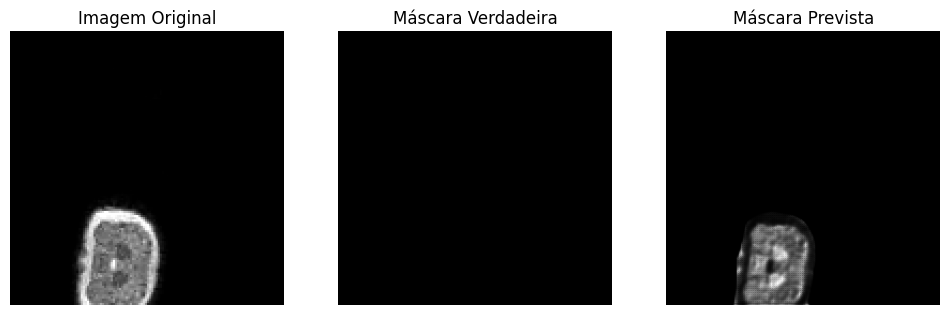

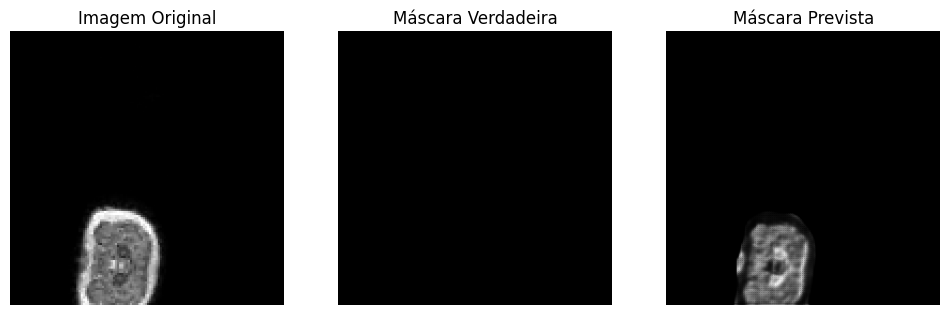

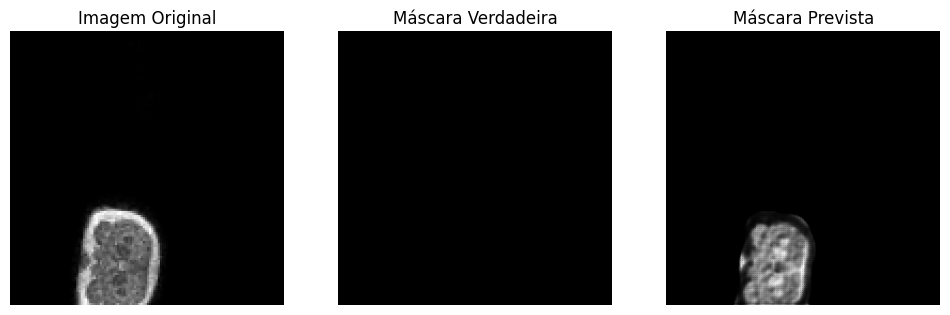

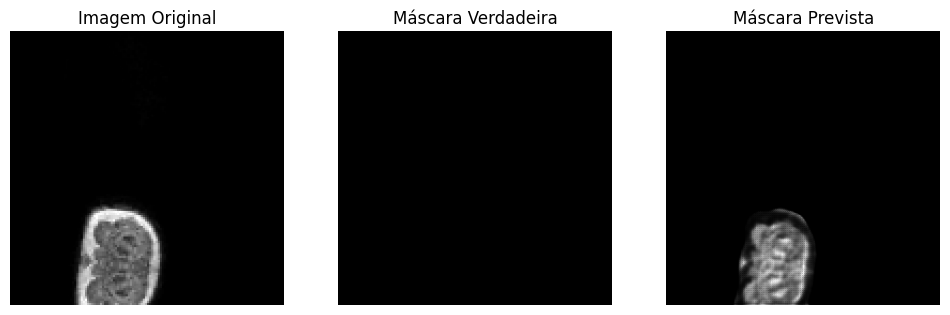

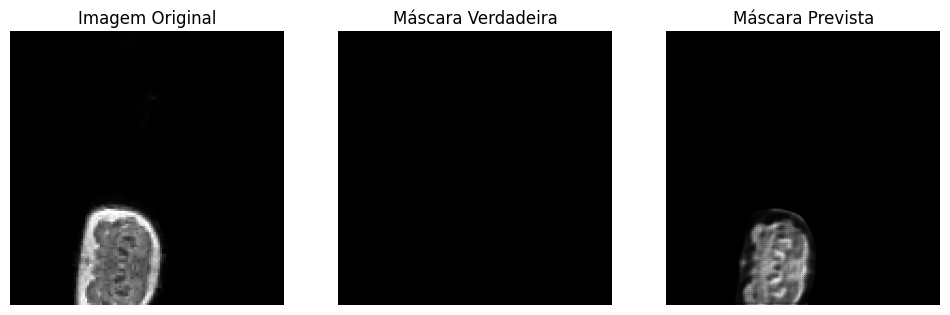

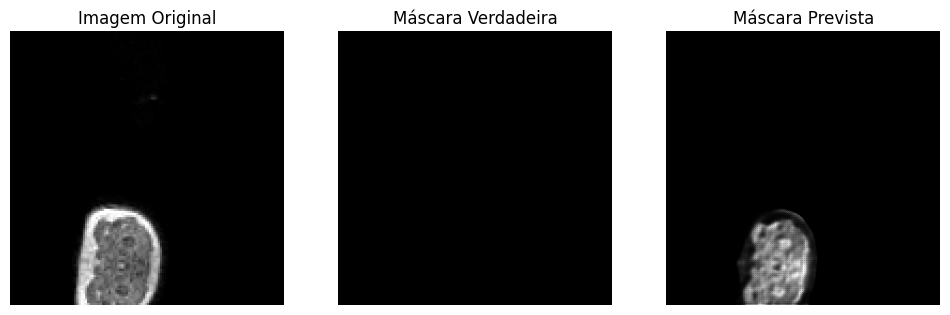

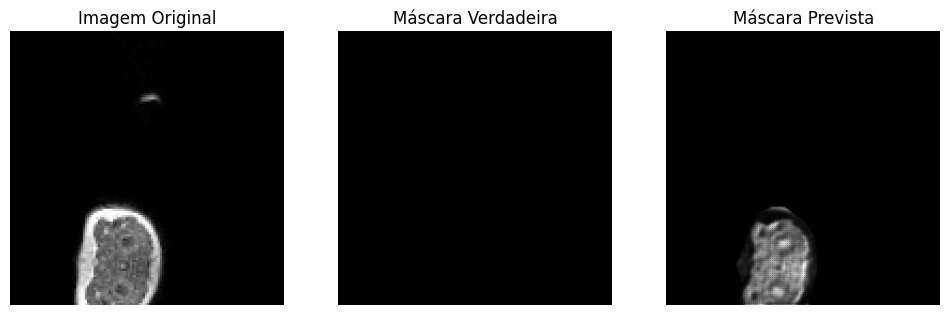

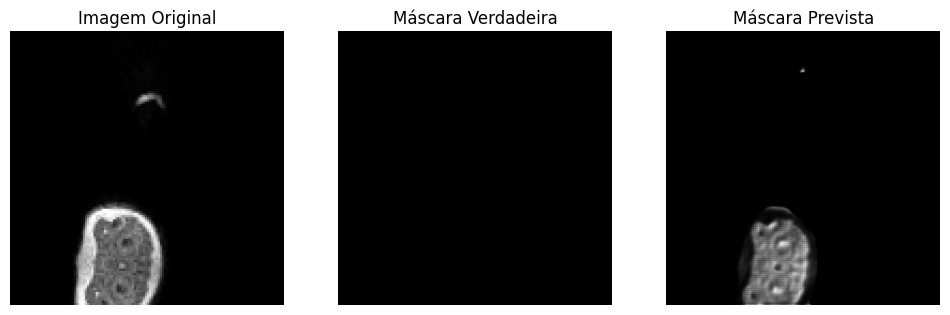

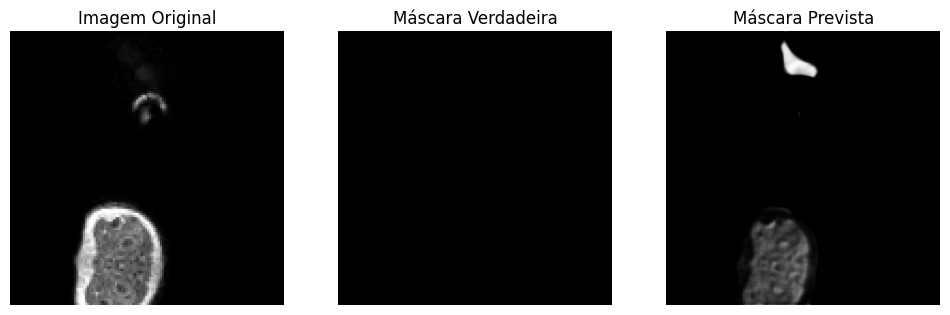

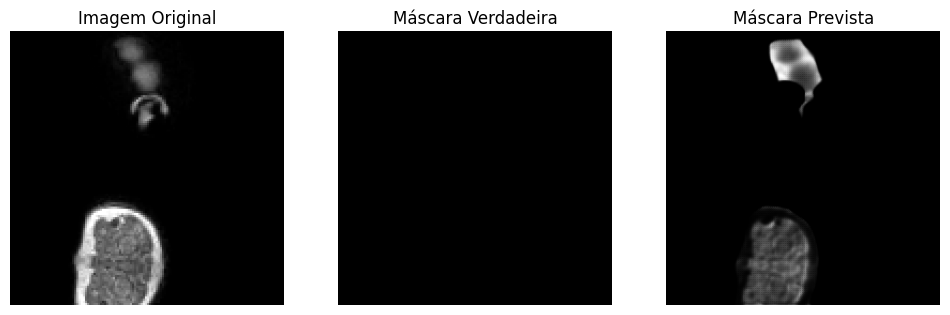

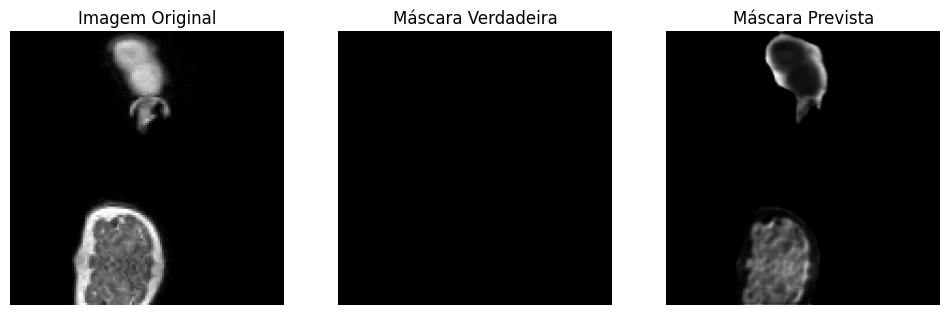

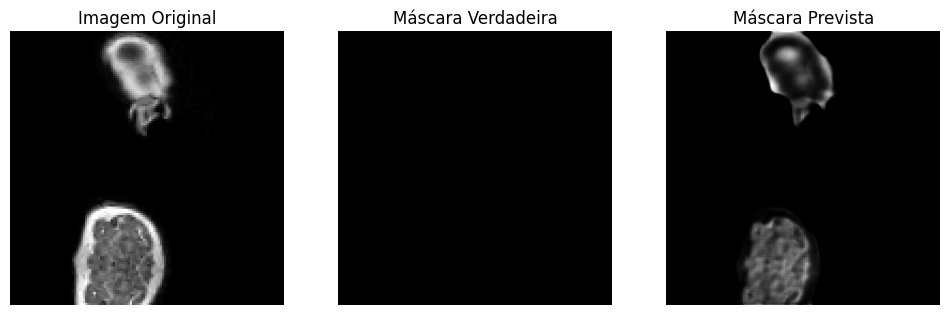

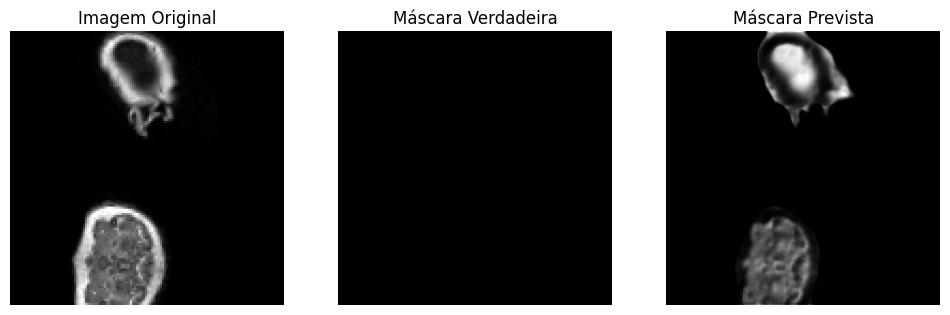

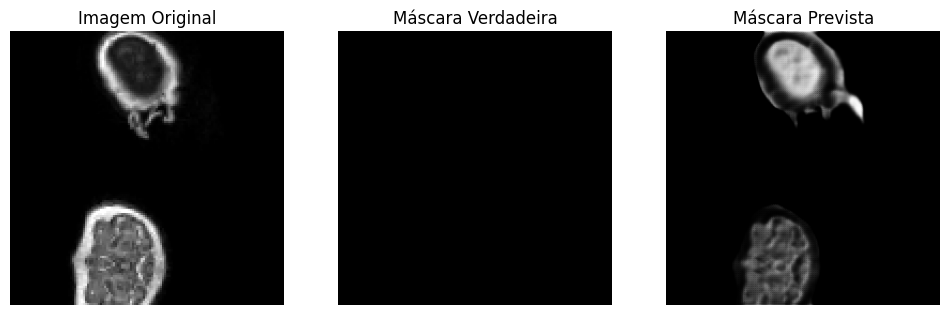

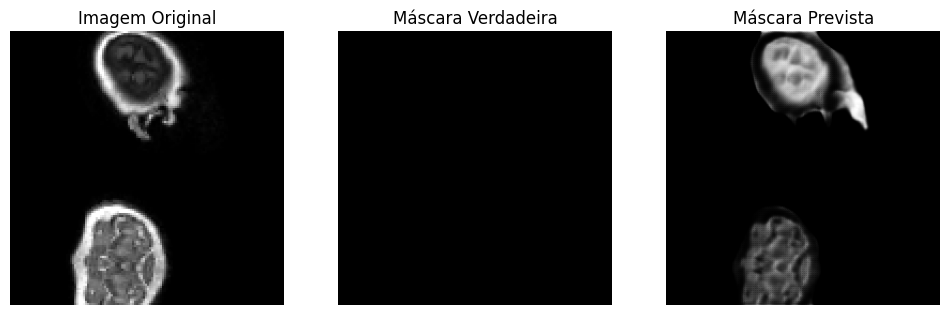

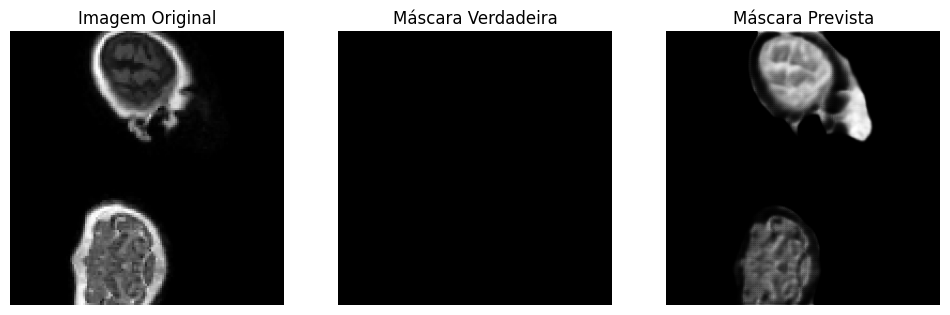

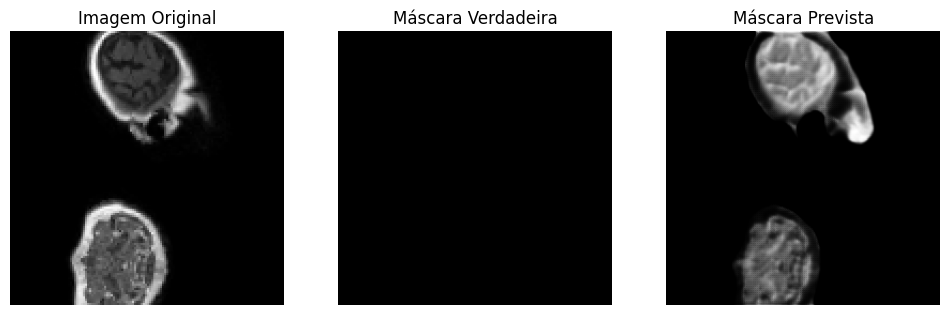

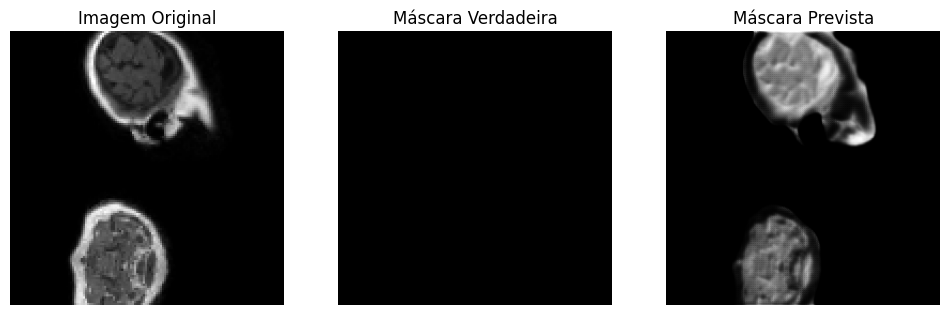

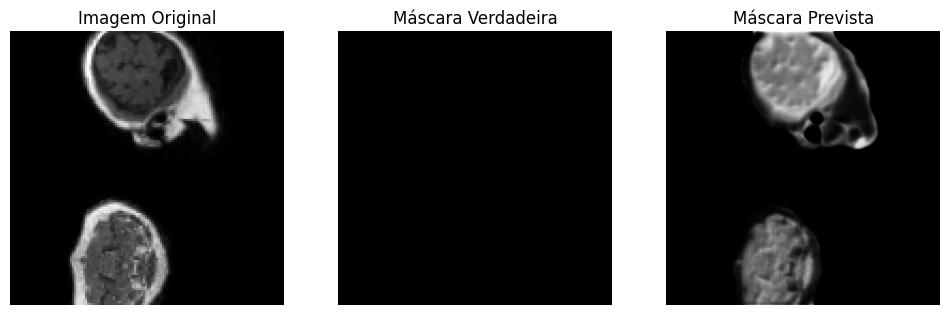

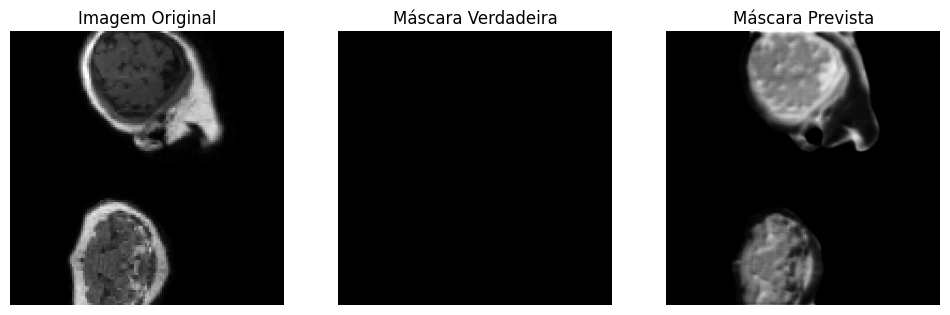

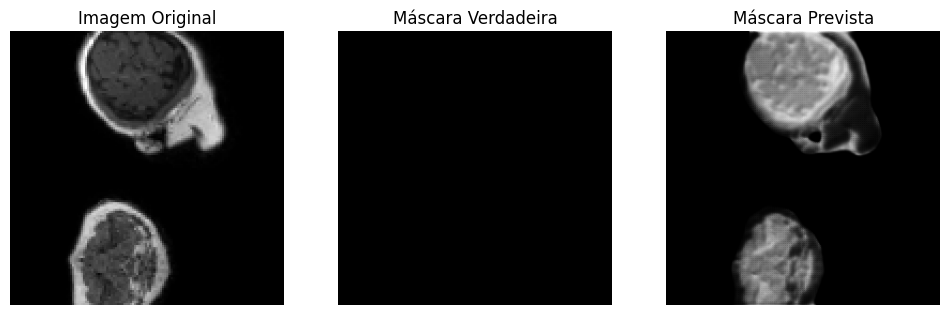

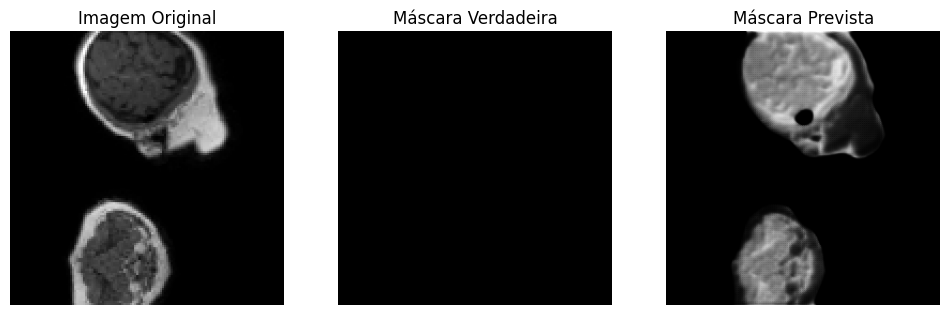

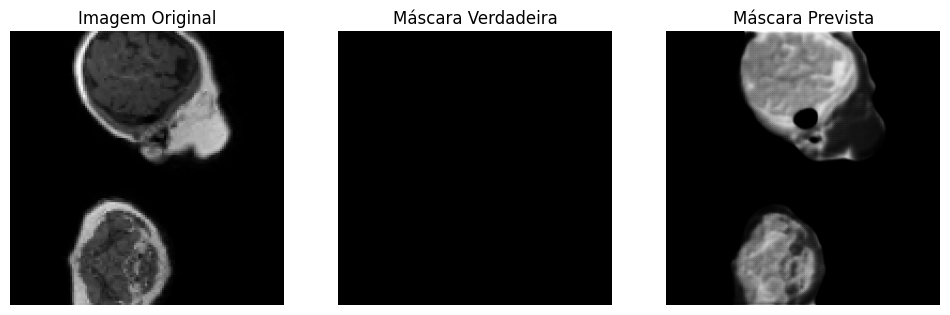

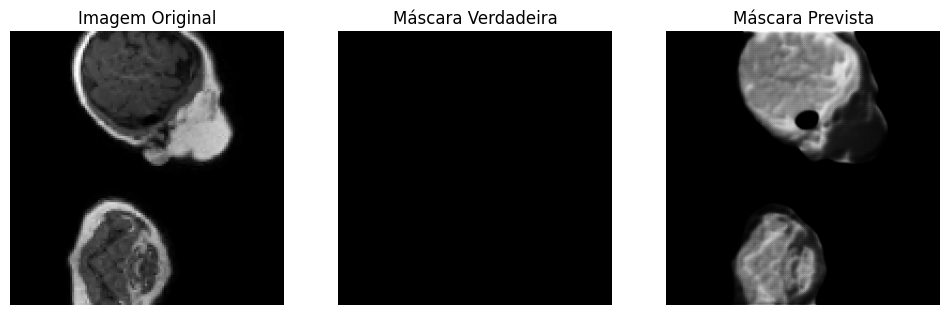

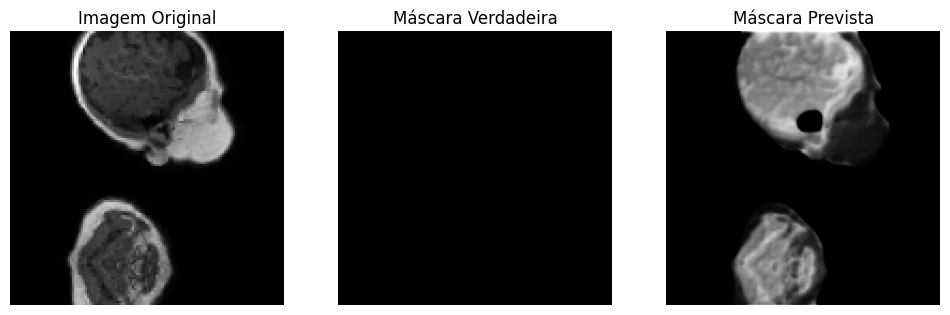

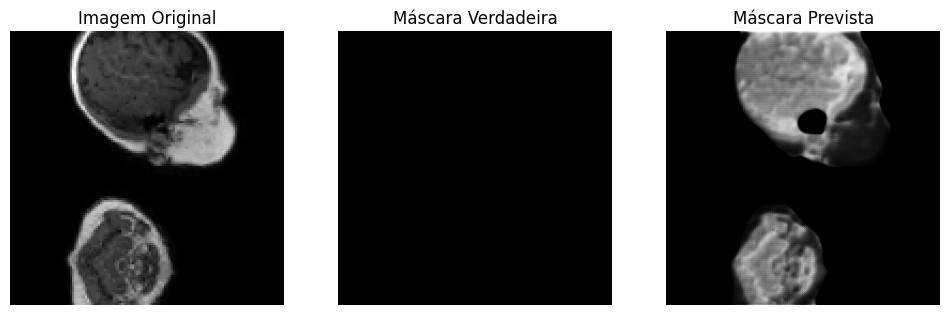

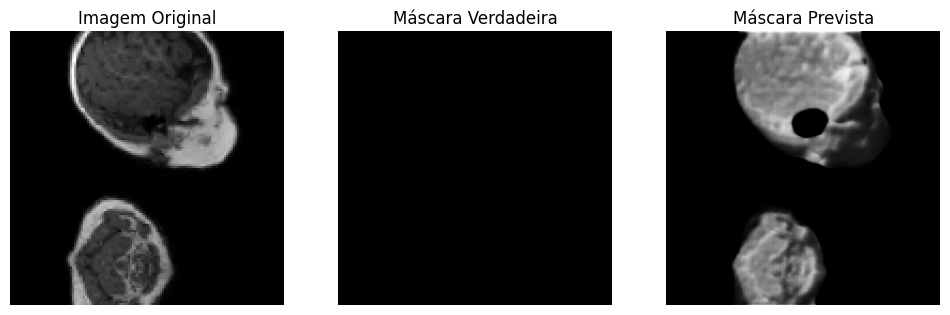

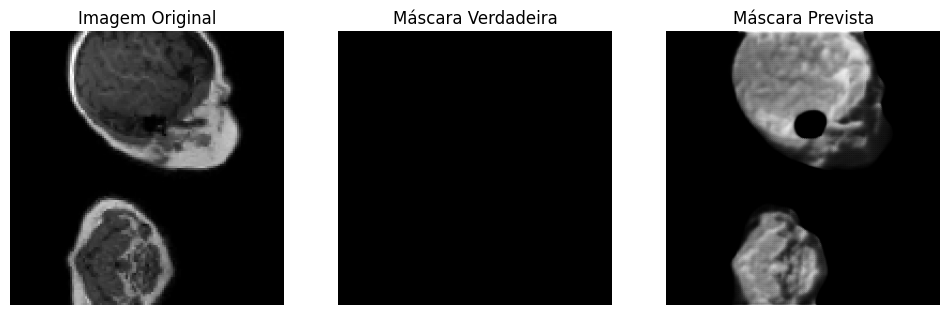

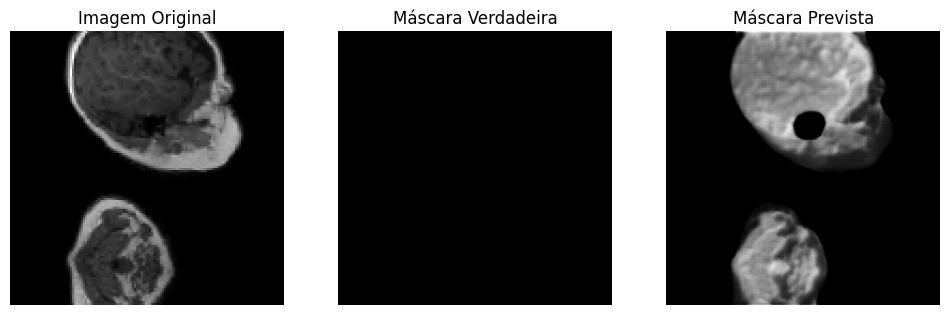

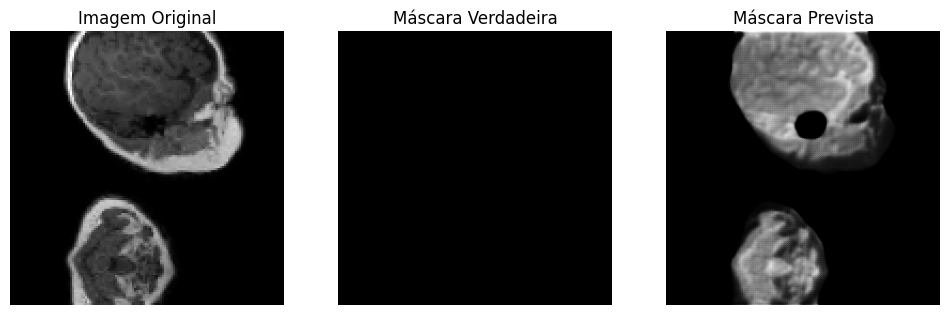

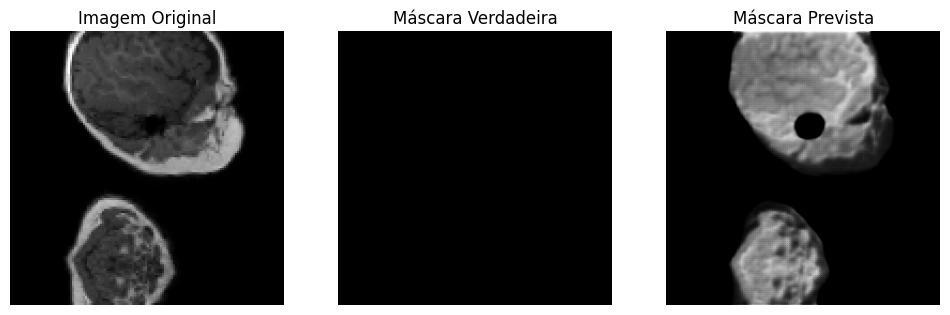

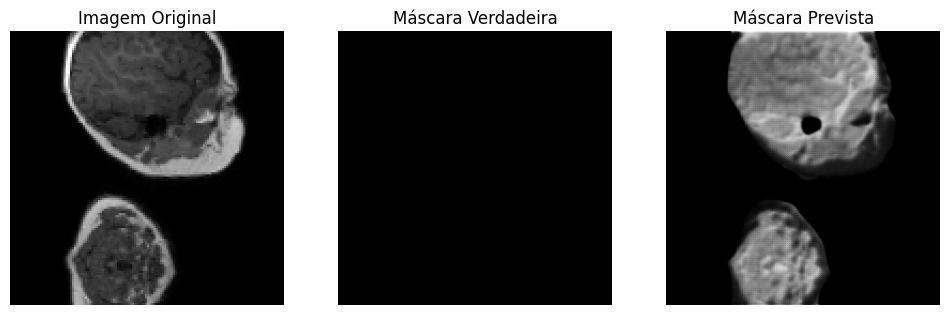

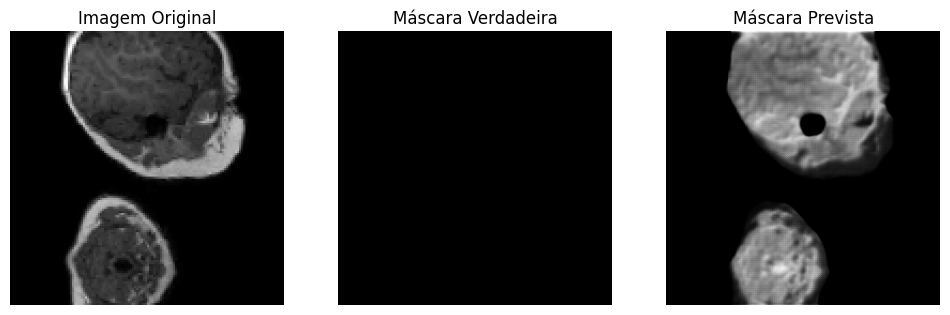

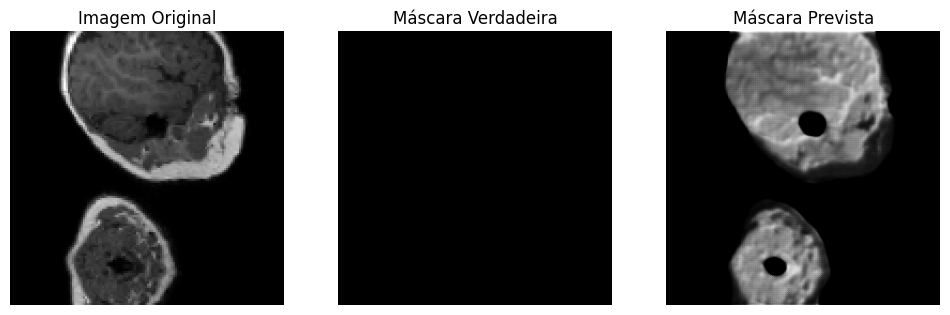

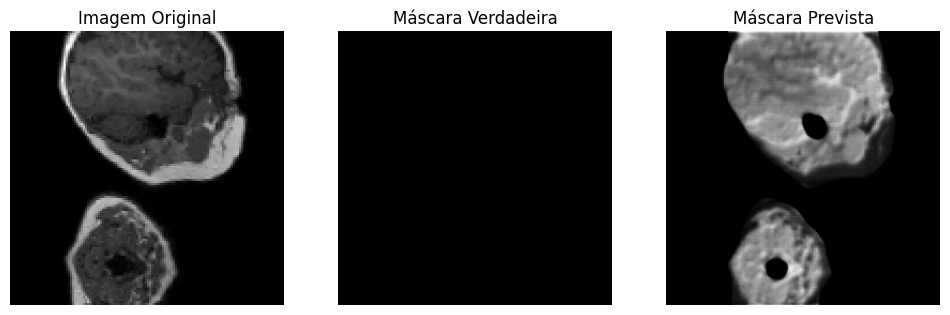

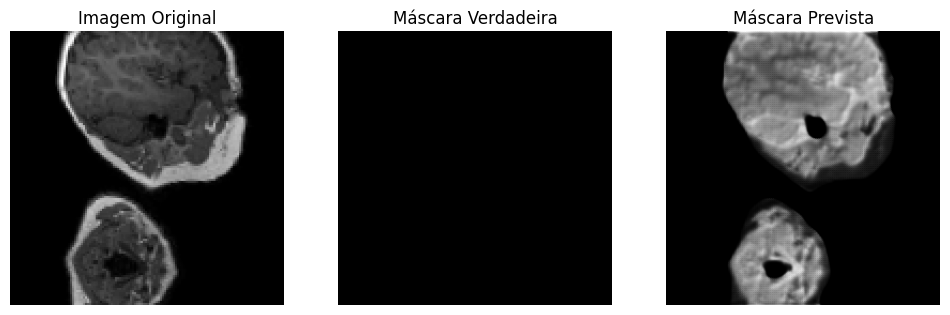

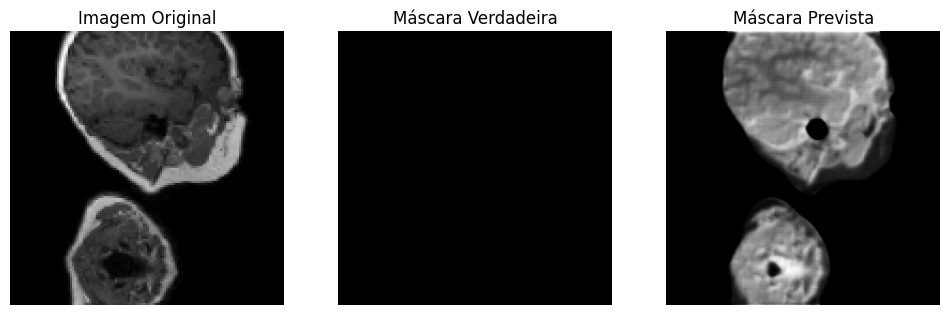

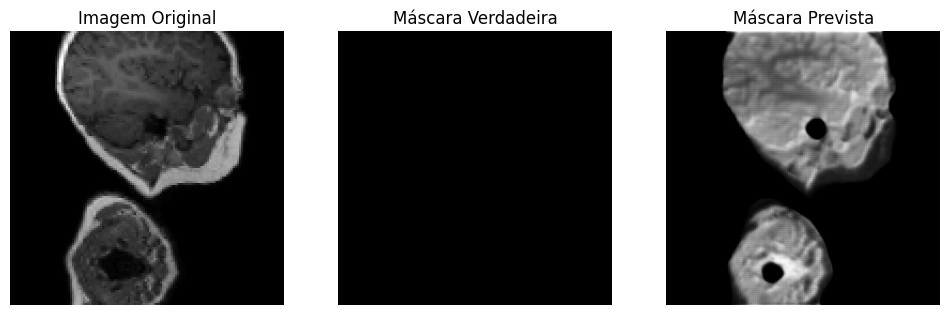

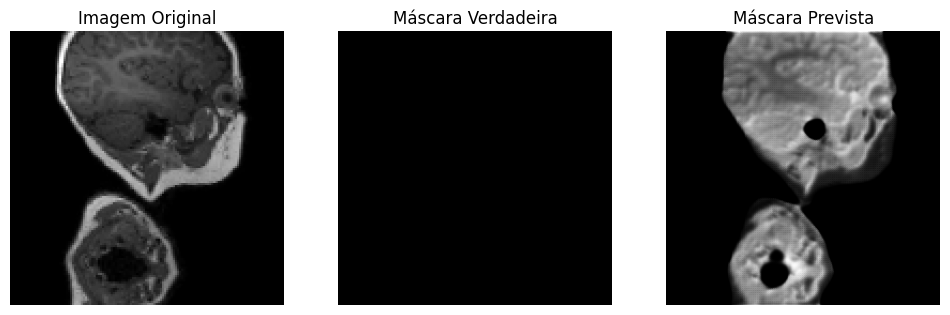

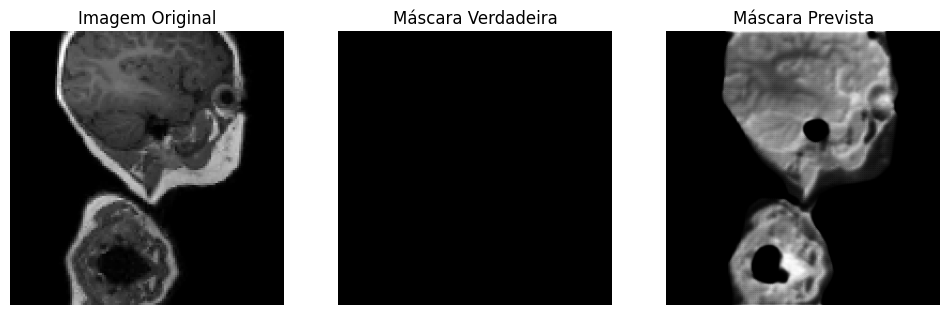

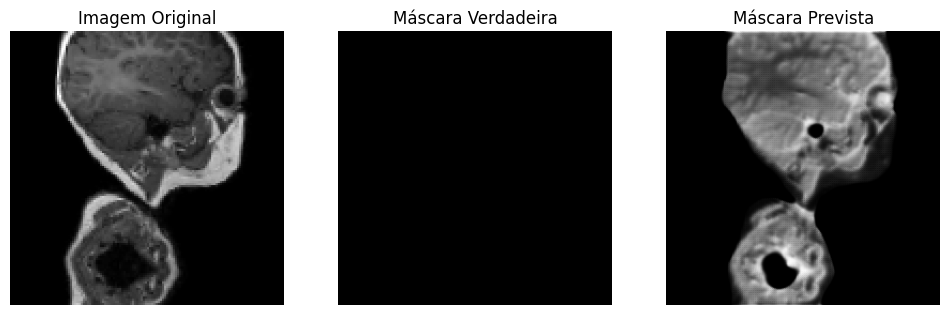

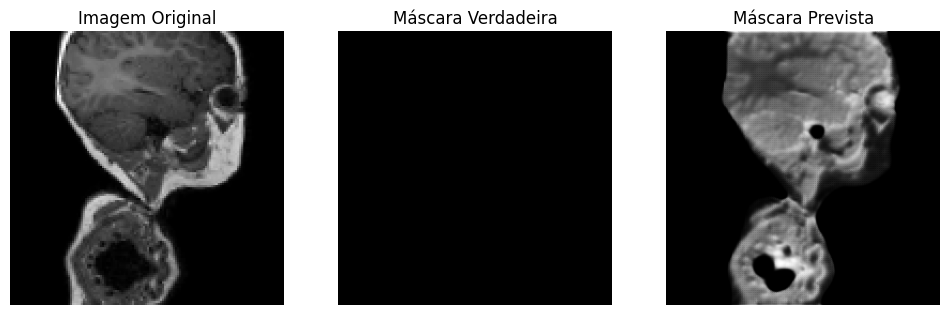

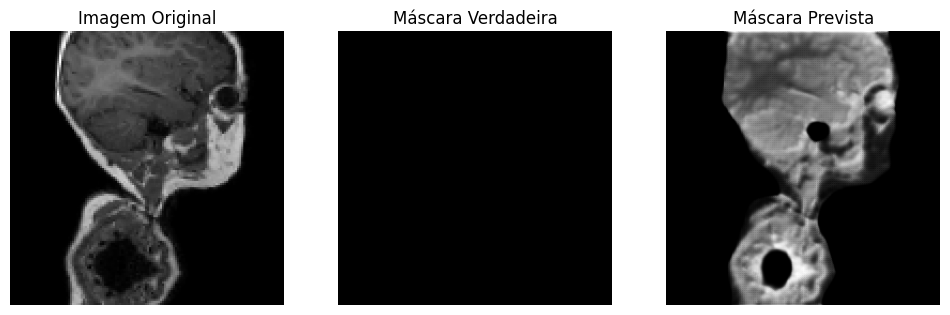

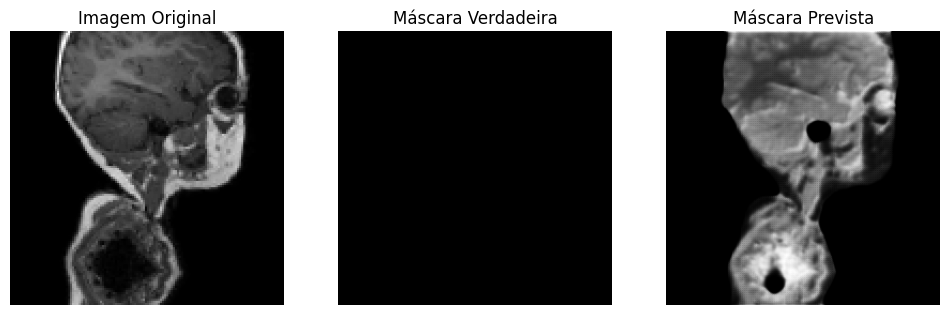

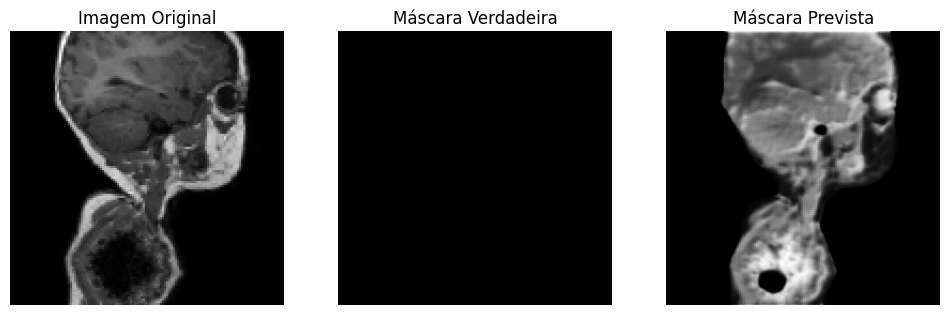

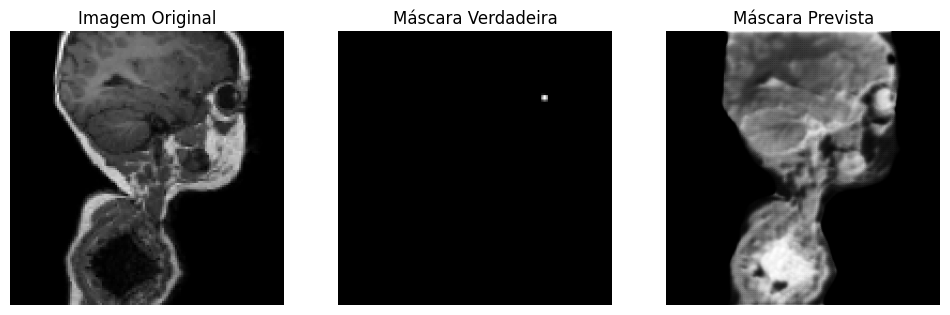

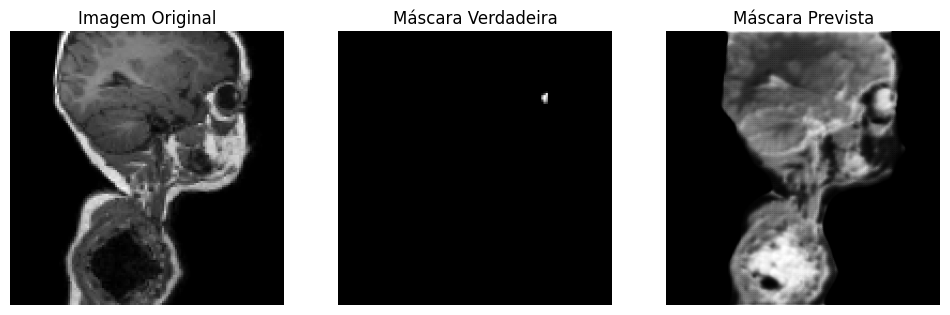

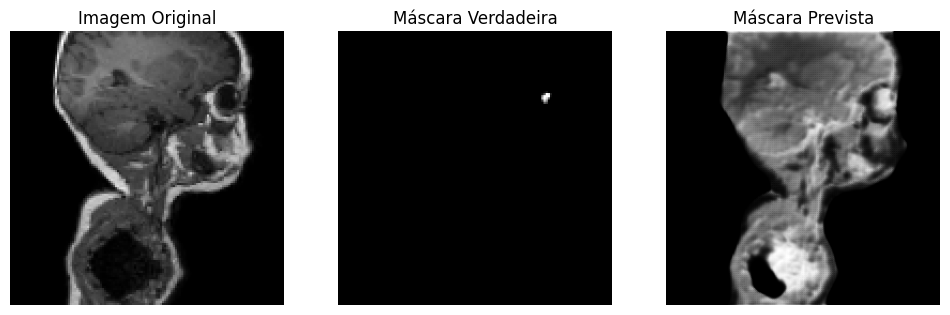

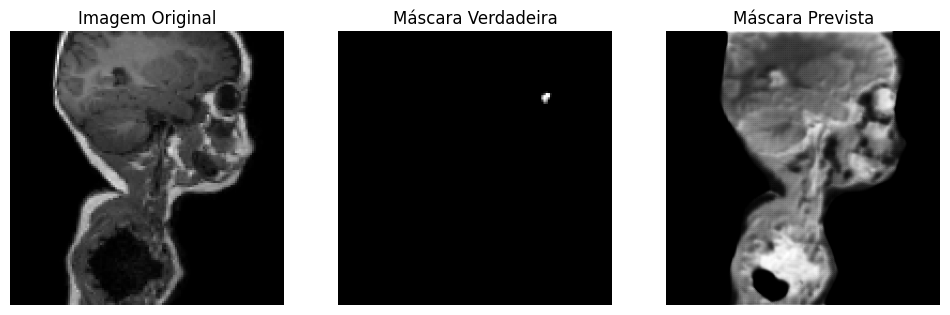

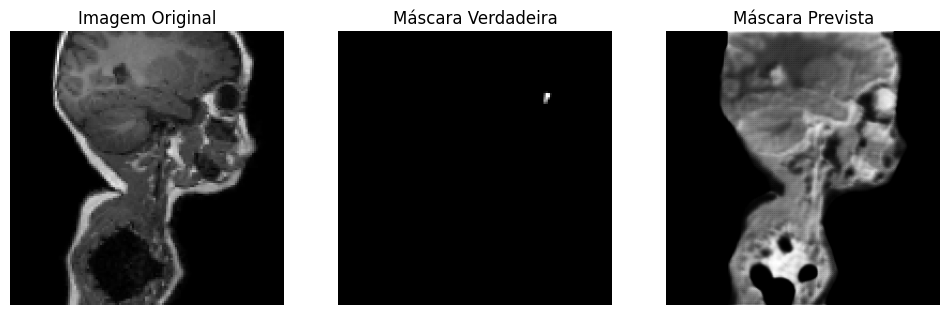

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(images, true_masks, pred_masks, n_samples=75):
   
    n_samples = min(n_samples, len(images), len(true_masks), len(pred_masks))
    
    for i in range(n_samples):
        plt.figure(figsize=(12, 4))

       
        plt.subplot(1, 3, 1)
        if isinstance(images[i], tf.Tensor):
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        else:
            plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Imagem Original")
        plt.axis('off')

      
        plt.subplot(1, 3, 2)
        if isinstance(true_masks[i], tf.Tensor):
            plt.imshow(true_masks[i].numpy().squeeze(), cmap='gray')
        else:
            plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("Máscara Verdadeira")
        plt.axis('off')

       
        plt.subplot(1, 3, 3)
        if isinstance(pred_masks[i], tf.Tensor):
            plt.imshow(pred_masks[i].numpy().squeeze(), cmap='gray')
        else:
            plt.imshow(pred_masks[i].squeeze(), cmap='gray')
        plt.title("Máscara Prevista")
        plt.axis('off')

        plt.show()

print("Shape of images:", sample_images.shape)
print("Shape of true_masks:", valmascaras.shape)
print("Shape of predictions:", predictions.shape)


plot_predictions(sample_images, valmascaras[:50], predictions, n_samples=75)